In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import os
import plotly.express as px
from scipy.fft import fft, fftfreq
import statistics
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import *

from IPython.display import clear_output

import yaml
import json
import time
import joblib
import itertools

# This function will probably be of most use to you. Provide the path to a data file and the state of the machine
# captured in that data and return a nicely formatted DataFrame. For example, if you want the very first file of
# the dataset, you would say:
#
# df = new_csv(csv='/path/to/MAFAULDA/data/full/normal/12.288.csv', 'normal')
#
# If you wanted something other than 'normal', you would just say:
#
# df = new_csv(csv='/path/to/MAFAULDA/data/full/imbalance/6g/13.9264.csv', 'imbalance')
#
# for the imbalance, you could try and classify whether there is an added weight of 6g,10g,15g,etc.. but I have
# kept the classification broad so far
def new_csv(csv=None,fault=None):
    df = pd.read_csv(csv)
    missing = []
    [missing.append(float(d)) for d in df.columns]
    df.columns = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']
    tempDf = pd.DataFrame(data=[missing],columns=df.columns,index=[0])
    df = pd.concat([tempDf,df],axis=0).reset_index().drop(columns=['index'])
    df['class'] = fault
    return df

# Check to see if a directory is a leaf or not. This is used later on for collecting data.
def is_leaf(path='.'):
    cwd = os.getcwd()
    os.chdir(path)
    check = sorted([f for f in os.listdir('./') if not f.startswith('.')], key=str.lower)
    os.chdir(cwd)
    if '.csv' in check[0]:
        return True
    else:
        return False
# Similar to reap_all_data() (found further down) but only collects vert simple data. Not used at the moment   
def reap_stat_data(path='.', df=None, dictionary=None, columns=None):
    cwd = os.getcwd()
    os.chdir(path)
    files = sorted([f for f in os.listdir('./') if not f.startswith('.')], key=str.lower)
    for f in files:
        data = pd.read_csv(f)
        missing = []
        [missing.append(float(d)) for d in data.columns]
        data.columns = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']
        missingDf = pd.DataFrame(data=[missing],columns=data.columns,index=[0])
        data = pd.concat([missingDf,data],axis=0)
        stats = data.describe()
        stats = stats.drop(index=['count','25%','50%','75%'],axis=0)
        tempDf = pd.DataFrame(columns=df.columns)
        for col in columns[:-1]:
            tempDf[col] = [stats[col[:-3]].iloc[dictionary[col[-3:]]]]
        classStr = path.split('/')
        tempDf['class'] = classStr[5]
        df = pd.concat([tempDf,df],axis=0)
    os.chdir(cwd)
    return df.reset_index().drop(columns=['index'])

# def walk_dirs(columns=None,codes=None,inputFrame=None,
#               finalFrame=None, walkDir=None):
    
#     for root, subdirs, files in os.walk(walkDir):

#         list_file_path = os.path.join(root, '')

#         print(list_file_path)
#         if is_leaf(path=list_file_path):
#             print('leaf')
#             data = reap_all_data(path=list_file_path,df=inputFrame,
#                                   dictionary=codes,columns=columns)
#             finalFrame = pd.concat([finalFrame,data],axis=0)

#         else:
#             print('not a leaf')
#     return finalFrame.reset_index().drop(columns='index')

# Given a parent directory, scan all sub-directories for data files and consolidate rows using SUMMARY STATISTICS
#
def walk_all_dirs(inputFrame=None,finalFrame=None, walkDir=None):
    
    for root, subdirs, files in os.walk(walkDir):

        list_file_path = os.path.join(root, '')

        print(list_file_path)
        if is_leaf(path=list_file_path):
            print('leaf')
            data = reap_all_data(path=list_file_path,df=inputFrame)
            finalFrame = pd.concat([finalFrame,data],axis=0)

        else:
            print('not a leaf')
    return finalFrame.reset_index().drop(columns='index')

def list_all_files(walkDir=None):
    files = []
    for root, subdirs, files in os.walk(walkDir):

        list_file_path = os.path.join(root, '')

        print(list_file_path)
        if is_leaf(path=list_file_path):
            files.append(sorted([f for f in os.listdir('./') if not f.startswith('.')], key=str.lower))
            print('leaf')
        else:
            print('not a leaf')
    return files

# Given a raw signal and our sampling rate, figure out the fundamental frequency of the signal using the method
# laid out in the papers.
def estimate_fundamental_frequency(sample=None,samp_per_sec=None):
    
    # values of the tachometer signal
    y = np.array(sample)
    # sample rate
    T = 1/samp_per_sec
    
    # calculate the Discrete Fourier Transform of the tachometer signal and
    # return the x values (frequency (Hz)) and the y values (magnitude)
    xf, yf = do_fft(y=y,T=T)
    
#     print(f'FROM EFF -- len: {len(xf)}')
    
    # initialize empty list that will hold candidates for the fundamental
    # frequency
    candidates = []
    idxs = []
    
    # scan the DFT for frequencies that may be candidates for the fundamental frequency.
    # Once a candidate has been found, mask it and the surrouding area to hone in on another.
    # return the list of candidates along with the modified x and y values for the DFT.
    for i in range(4):
        # find the frequency with the highest magnitude and return the x and y values
        maxIdx, argmax = find_highest_frequency(xf,yf)
#         print(f'FROM EFF -- maxIdx: {maxIdx}')
        # store the value of this frequency in candidates
        candidates.append(argmax)
        idxs.append(maxIdx)
        # mask the located frequency and it's neighbors [-3,+3] with zeros
#         zone = yf[maxIdx-3:maxIdx+4]
#         print(zone.shape)
#         if zone.shape != (7,):
#             print(yf)
#         zone = np.zeros(7)

        lo = maxIdx-3
        hi = maxIdx+4
        
        # this covers the case where the argmax is {0,1,2} and would cause the initial index to be less than 0
        if lo < 0:
            lo-=lo
        
        # if everything is working as usual, width should be 7
        # else, width becomes a smaller value. This means we are zeroing out an area from [0,hi+1]
        width = hi-lo
        
        yf[lo:hi] = np.zeros(width)
        
        
#         yf[maxIdx-3:maxIdx+4] = np.zeros(7)
    
    return candidates, idxs, xf, yf

# Given the X and Y spectral coordinates, find the highest peak and return the magnitude and the frequency
def find_highest_frequency(xf=None,yf=None):
    
    maxIdx = np.argmax(yf)
    argmax = xf[maxIdx]
    
    return maxIdx, argmax

# Given a raw signal, for example the Tachometer Signal from full/normal/12.288.csv, and 1/(sampling frequency
# in Hz), return the X and Y coordinates of the spectrum. In our case, the sampling frequency is 50kHz, or 50000Hz
def do_fft(y=None,T=None):
    
    
    N = len(y)
    
    yf = fft(y)[0:N//2]
    xf = fftfreq(N,T)[:N//2]
    yf = 2.0/N * np.abs(yf)
    
    return xf, yf

# Given the X and Y coordinates gathered from the above function do_fft(), simply plot them out in an interactive
# manner using plotly
def plot_fft(xf=None,yf=None):
    
    f = pd.DataFrame(columns={'x','y'})
    f['x'] = xf
    f['y'] = yf
    fig = px.line(f,x='x',y='y', title='Spectral Analysis (FFT)',
                  labels=dict(
                         x='frequency',
                         y='magnitude')
                   )
    
    return fig
    
# Given a parent directory, scan for data files and consolidate all 250,000 rows in each file 
# down to 1 using the supplied functions. This converts raw data into SUMMARY STATISTICS and should only be used
# when not wanting to work with the entire dataset. The data gathered from this might be useful just to get
# something running as a proof of concept, but it does take some time to consilidate all the data. Called by
# walk_all_dirs()
def reap_all_data(path='.', df=None):
    columns = df.columns
    cwd = os.getcwd()
    os.chdir(path)
    files = sorted([f for f in os.listdir('./') if not f.startswith('.')], key=str.lower)
    for f in files:
        data = pd.read_csv(f)
        missing = []
        [missing.append(float(d)) for d in data.columns]
        data.columns = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']
        missingDf = pd.DataFrame(data=[missing],columns=data.columns,index=[0])
        data = pd.concat([missingDf,data],axis=0)
        tempDf = pd.DataFrame(columns=df.columns)
        candidates, idxs, xf, yf= estimate_fundamental_frequency(sample=data['tachometerSignal'],
                                                                 samp_per_sec=50000)
        #print(np.min(candidates))
        
        #print(columns)
        for col in columns[:-2]:
            
            _col = col.split('-')
            #print(col)
            featureName = _col[0] # Ex: axialOverhang
            statName = _col[1]    # Ex: Mean
            #print(f'featureName: {featureName}')
            #print(f'statName: {statName}')
            
            if statName == 'Entropy':
                tempDf[col] = [stats.entropy(data[featureName].value_counts())]
                #break
            elif statName == 'Kurtosis':
                tempDf[col] = [stats.kurtosis(data[featureName])]
                #break
            elif statName == 'Mean':
                tempDf[col] = [np.mean(data[featureName])]
                #break
            ##############################################
            elif statName == 'Std':
                tempDf[col] = [np.std(data[featureName])]
                #break
            elif statName == 'Min':
                tempDf[col] = [np.min(data[featureName])]
                #break
            elif statName == 'Max':
                tempDf[col] = [np.max(data[featureName])]
                #break
            ##############################################
            elif statName == 'F':
                spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                     samp_per_sec=50000,
                                                     idxs=idxs)
                tempDf[col] = [spectrals[0][0]]
                #break
            elif statName == '2F':
                spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                     samp_per_sec=50000,
                                                     idxs=idxs)
                tempDf[col] = [spectrals[0][1]]
                #break
            elif statName == '3F':
                spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                     samp_per_sec=50000,
                                                     idxs=idxs)
                tempDf[col] = [spectrals[0][2]]
                #break
        classStr = path.split('/')
        tempDf['fundamentalFrequency'] = np.min(candidates)
        tempDf['path'] = os.getcwd().split('data/')[-1]+'/'+f
        tempDf['class'] = os.getcwd().split('full/')[-1]
        #print(tempDf.head())
        df = pd.concat([tempDf,df],axis=0)
    os.chdir(cwd)
    return df.reset_index().drop(columns=['index'])

# extract the spectral features laid out in the paper.
# given a sample, or in more exact terms, all of the rows corresponding to a single column in a data file,
# AKA a whole signal, take the FFT and find the magnitude of the spectrum at F, 2F, and 3F. F is the fundamental
# frequency of a signal and can be found by estimate_fundamental_frequency()
def extract_spectral_feature(sample=None,samp_per_sec=None,idxs=None):
    
    # do fft and return x and y coordinates
    xf,yf = do_fft(y=sample,T=1/samp_per_sec)
    
    # these are the candidates for the fundamental frequency and just so happen to be F, 2F, 3F, and 4F
    idxs.sort()
    
    # we only need F, 2F, and 3F
    spectrals = [yf[idxs[0]], 
                 yf[idxs[1]], 
                 yf[idxs[2]]]
    
    return spectrals, xf,yf

# not used. can find 2*F and 3*F with the candidates list
def find_nearest_peak(idx=None,yf=None):
    
    right = idx + 1
    left = idx - 1
    prev = idx
        
    if yf[right] > yf[left]:
        current = right
        while yf[current] > yf[prev]:
            current+=1
            prev+=1
    
    elif yf[left] > yf[right]:
        current = left
        while yf[current] > yf[prev]:
            current-=1
            prev-=1
    
    return prev

def list_all_files(walkDir=None):
    f = []
    for root, subdirs, files in os.walk(walkDir):

        list_file_path = os.path.join(root, '')

#         print(list_file_path)
        if is_leaf(path=list_file_path):
            t = sorted([f for f in os.listdir(list_file_path) if not f.startswith('.')], key=str.lower)
            [f.append(list_file_path+_) for _ in t]
#             f.append(t)
#             print(f'{list_file_path} -> leaf')
#         else:
#             print(f'{list_file_path} -> not a leaf')
    return f

# Plots a confusion matrix next to a histogram to show the ratio of TF/FP TN/FN after predicting with our
# classifier model. The purpose of the histogram is to show the distribution of each of the classes since there
# is some notable disparity in this dataset. Ex: normal only has 49 measurements wheres imbalance has 333
# measurements (data files)
# codes: classes get ingested by the classifier model as numerical values, so codes is just a dictionary that
# says which value corresponds to which class
def confusion_hist_plot(df=None,y_test=None,preds=None,codes=None):
    
    fig, ((ax1),(ax2)) = plt.subplots(1,2,figsize=(20,8),sharey=False)
    
    cm = confusion_matrix(y_test,preds,normalize='true')
    _cm = confusion_matrix(y_test,preds,normalize=None)
    sns.heatmap(cm, annot=_cm, cmap='Blues',ax=ax1)
    
    v = [*y_test.values]
    v.extend([*preds])
    v = [*set(v)]
    v = pd.Series(v).map(dict(map(reversed,codes.items())))
    keys_to_extract = v.values
    codes = {key: codes[key] for key in keys_to_extract}
        
    ax1.set_xticklabels(codes.keys(),rotation=45)
    ax1.set_yticklabels(codes.keys(),rotation=0)

    histData = pd.DataFrame(data=y_test,columns=[target])
    
    keyDf=histData[target].map(dict(map(reversed,codes.items())))
    orderedDf = pd.Categorical(keyDf,categories=[*codes.keys()],ordered=True)
    sns.histplot(y=orderedDf,ax=ax2,color='cornflowerblue',linewidth=1.75)
#     ax2.set_yticklabels(classDict.keys(),rotation=45)

    acc = accuracy_score(y_test,preds)
    plt.suptitle(f'Confusion Matrix With Supporting Histogram\naccuracy score: {acc:.4f}')
    return fig
#     fig.suptitle("Confusion Matrix With Supporting Histogram", fontsize=14)

def summarize(df=None,columns=None):
    columns = columns
    data = df.copy()
    tempDf = pd.DataFrame()
    classes = np.unique(data['class'])
#     print(classes)
#     print(data.index)
    
    if len(classes) > 1:
        tempDf['class'] = ['mixed']
    else:
        tempDf['class'] = [classes[0]]
    
    data = data.drop(columns=['class'])
        
    candidates, idxs, xf, yf= estimate_fundamental_frequency(sample=data['tachometerSignal'],
                                                             samp_per_sec=50000)
    #print(np.min(candidates))

    #print(columns)
    for col in columns[:-2]:

        _col = col.split('-')
        #print(col)
        featureName = _col[0] # Ex: axialOverhang
        statName = _col[1]    # Ex: Mean
        #print(f'featureName: {featureName}')
        #print(f'statName: {statName}')

        if statName == 'Entropy':
            tempDf[col] = [stats.entropy(data[featureName].value_counts())]
            #break
        elif statName == 'Kurtosis':
            tempDf[col] = [stats.kurtosis(data[featureName])]
            #break
        elif statName == 'Mean':
            tempDf[col] = [np.mean(data[featureName])]
            #break
        ##############################################
        elif statName == 'Std':
            tempDf[col] = [np.std(data[featureName])]
            #break
        elif statName == 'Min':
            tempDf[col] = [np.min(data[featureName])]
            #break
        elif statName == 'Max':
            tempDf[col] = [np.max(data[featureName])]
            #break
        ##############################################
        elif statName == 'F':
            spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                 samp_per_sec=50000,
                                                 idxs=idxs)
            tempDf[col] = [spectrals[0][0]]
            #break
        elif statName == '2F':
            spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                 samp_per_sec=50000,
                                                 idxs=idxs)
            tempDf[col] = [spectrals[0][1]]
            #break
        elif statName == '3F':
            spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                 samp_per_sec=50000,
                                                 idxs=idxs)
            tempDf[col] = [spectrals[0][2]]
            #break
#     classStr = path.split('/')
    tempDf['fundamentalFrequency'] = np.min(candidates)
#     path = np.unique(df['path'])
#     tempDf['path'] = path
#     tempDf['class'] = [p.split('full/')[-1] for p in path]
    #print(tempDf.head())
    return tempDf.reset_index().drop(columns=['index'])

def plot_window( df=None, n=2, back_colors=['r','b'],
                 trues=None, preds=None,
                 fig_size=(14,26), p_color='C0', t_color='C1',
                 p_alpha=0.8, t_alpha=0.4, class_dict=None,
                 window_width=10000, width_per_step=10000):
    
    data_reindexed = df.reset_index().drop(columns=['index'])
    l = len(data_reindexed)/n
    sigs = data_reindexed.columns[:-2]
    n_plots = len(sigs)+1

    fig = plt.figure()

    # to change size of subplot's
    # set height of each subplot as 8
    fig.set_figheight(16)

    # set width of each subplot as 8
    fig.set_figwidth(14)

    # create grid for different subplots
    spec = gridspec.GridSpec(ncols=1, nrows=n_plots,
                             width_ratios=[1], wspace=0.5,
                             hspace=0.5, height_ratios= [*np.ones(n_plots-1)]+[2])

    for i in range(n_plots):
        tick = len(data_reindexed)/5
        xticks = np.arange(0,len(data_reindexed)+tick,tick)
        ax = fig.add_subplot(spec[i])
        if i < n_plots-1:
            ax.plot(data_reindexed[sigs[i]],label=sigs[i])
            for _ in range(n):
                ax.axvspan(l*_, (l*_)+l, facecolor=back_colors[_%2], alpha=0.13)
            ax.axvspan(50000,50000+window_width,facecolor='y',alpha=.35)
            ax.set_xticks(xticks)
            ax.set_xticklabels(['']*len(xticks))
        else:
#             ax.scatter(np.arange(window_width,(l*n)+width_per_step,width_per_step),preds,
#                        label='predicted class',facecolors='none',edgecolors=p_color,alpha=p_alpha)
#             ax.scatter(np.arange(window_width,(l*n)+width_per_step,width_per_step),trues,
#                        label='true class',facecolors='none',edgecolors=t_color,alpha=t_alpha)
            ax.scatter(np.arange(window_width,(l*n),width_per_step),preds,
                       label='predicted class',facecolors='none',edgecolors=p_color,alpha=p_alpha)
            ax.scatter(np.arange(window_width,(l*n),width_per_step),trues,
                       label='true class',facecolors='none',edgecolors=t_color,alpha=t_alpha)
            ax.set_yticks([*class_dict.values()])
            ax.set_yticklabels([*class_dict.keys()])
            ax.set_xticks(xticks)
            for _ in range(n):
                ax.axvspan(l*_, (l*_)+l, facecolor=back_colors[_%2], alpha=0.13)
        ax.legend()
    acc = accuracy_score(trues[trues!=6],pd.Series(preds)[trues!=6])
    fig.suptitle(f'\n\n\n\n{window_width} wide window and {width_per_step} width per step\nAccuracy: {round(acc*100,2)}%')
#     plt.show()
    return fig, acc
    
#     fig, axs = plt.subplots(n_plots,figsize=fig_size,sharex=True)

#     for i,ax in enumerate(axs):
#         if i < n_plots-1:
#             ax.plot(data_reindexed[sigs[i]],label=sigs[i])
#             for _ in range(n):
#                 ax.axvspan(l*_, (l*_)+l, facecolor=back_colors[_%2], alpha=0.13)
#             ax.axvspan(50000,10000,facecolor='y',alpha=.35)
#         else:
#             ax.scatter(np.arange(window_width,(l*n)+width_per_step,width_per_step),preds,
#                        label='predicted class',facecolors='none',edgecolors=p_color,alpha=p_alpha)
#             ax.scatter(np.arange(window_width,(l*n)+width_per_step,width_per_step),trues,
#                        label='true class',facecolors='none',edgecolors=t_color,alpha=t_alpha)
#             ax.set_yticks([*class_dict.values()])
#             ax.set_yticklabels([*class_dict.keys()])
#             for _ in range(n):
#                 ax.axvspan(l*_, (l*_)+l, facecolor=back_colors[_%2], alpha=0.13)
#         ax.legend()
    fig.suptitle(f'{window_width} window width and {width_per_step} width per step')

def prepare_window_data( data_path='~/ML/MAFAULDA/data/', steps_per_file=250000, num_files=2,
                         sensors=None, file_idxs=None ):
    df = pd.DataFrame(columns=sensors)
    val_files = pd.read_csv('./utils/val_files.csv').set_index('Unnamed: 0')
    
    if file_idxs is None:
        for i in range(num_files):
            p = data_path+val_files['path'].iloc[i]
            tempDf = pd.read_csv(p,header=None)
            tempDf.columns = sensors
            tempDf['path'] = [p]*steps_per_file
            tempDf['class'] = [p.split('full/')[-1].split('/')[0]]*steps_per_file
            df = pd.concat([df,tempDf])
    else:
        num_files = len(file_idxs)
        for i in file_idxs:
            p = data_path+val_files[val_files.index == i]['path'].values[0]
            tempDf = pd.read_csv(p,header=None)
            tempDf.columns = sensors
            tempDf['path'] = [p]*steps_per_file
            tempDf['class'] = [p.split('full/')[-1].split('/')[0]]*steps_per_file
            df = pd.concat([df,tempDf])
        
    return df

def slide_window( window_width=10000,width_per_step=10000,window_model=None,
                  num_files=2, df=None, columns=None, steps_per_file=250000 ):
    
    # sliding window hyper-parameters
#     window_width = 10000
#     width_per_step = 2500
#     window_model = model

    preds, trues = [],[]
#     for i in range(0,(steps_per_file*num_files)-window_width+width_per_step,width_per_step):
    for i in range(0,(steps_per_file*num_files)-window_width,width_per_step):
        data = df.iloc[i:i+window_width]
#         print(f'{i}:{i+window_width}')
        summarized = summarize(df=data,columns=columns)
        X = summarized.drop(columns=['class'])
        y = summarized['class'].map(classDict).values[0]
        pred = window_model.predict(X)[0]
        preds.append(pred)
        trues.append(y)

    # unique_values = []
    # unique_values.extend(preds)
    # unique_values.extend(trues)
    # unique_values = [*set(unique_values)]

    trues = pd.Series(trues)
    return trues, preds

def plot_feature_importance(model=None, X=None, figsize=None):
    feature_names = X.columns
    importance_frame = pd.DataFrame()
    importance_frame['Features'] = X.columns
    importance_frame['Importance'] = model.feature_importances_ #coef_
    importance_frame = importance_frame.sort_values(by=['Importance'], ascending=True)

    plt.figure(figsize=figsize)
    plt.barh(np.arange(1,len(X.columns)+1), importance_frame['Importance'], align='center', alpha=0.5)
    plt.yticks(np.arange(1,len(X.columns)+1), importance_frame['Features'])
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('axes', titlesize=16)
    return importance_frame


In [2]:
df = pd.read_csv('/Users/nrprzybyl/ML/MAFAULDA/data/complex_mafaulda_new.csv')
df.head()

,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F,axialUnderhang-3F,axialOverhang-Entropy,axialOverhang-Kurtosis,axialOverhang-Mean,axialOverhang-F,...,microphone-Mean,microphone-F,microphone-2F,microphone-3F,tachometerSignal-Entropy,tachometerSignal-Kurtosis,tachometerSignal-Mean,fundamentalFrequency,class,path
0,11.700423,-0.028423,0.009096,0.209861,0.089478,0.081119,11.251919,0.144682,0.004352,0.020866,...,0.011994,0.028085,0.006391,0.022628,10.081655,1.920819,0.000409,60.6,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
1,11.691405,-0.315841,0.009299,0.171966,0.080338,0.063176,11.453312,0.634057,0.018882,0.015441,...,0.011745,0.025441,0.006911,0.024714,10.098573,2.051371,0.001856,59.2,vertical-misalignment,full/vertical-misalignment/1.78mm/60.6208.csv
2,11.691603,-0.314269,0.008901,0.167616,0.196603,0.045823,11.107915,0.434333,-0.011894,0.031162,...,0.011845,0.032116,0.021273,0.017417,10.207887,2.071535,-0.001486,58.6,vertical-misalignment,full/vertical-misalignment/1.78mm/60.0064.csv
3,11.715946,-0.040901,0.008365,0.172601,0.067104,0.116394,11.246643,0.829039,0.005535,0.022489,...,0.012393,0.027578,0.006499,0.020195,10.088735,2.064658,-0.001532,57.2,vertical-misalignment,full/vertical-misalignment/1.78mm/58.5728.csv
4,11.713568,-0.129168,0.008913,0.164138,0.064997,0.150388,11.184626,-0.092772,0.009297,0.017579,...,0.012543,0.025544,0.007792,0.023317,10.097232,2.038316,-0.000936,56.0,vertical-misalignment,full/vertical-misalignment/1.78mm/57.344.csv


In [3]:
# make our class dictionary
keys = list(np.unique(df['class']))
codes = [int(_) for _ in np.arange(0,len(keys))]
classDict = dict(zip(keys,codes))
classDict['mixed'] = 6
classDict
# with open(f'./utils/classes.json', 'w') as file:
#         file.write(json.dumps(classDict))

{'horizontal-misalignment': 0,
 'imbalance': 1,
 'normal': 2,
 'overhang': 3,
 'underhang': 4,
 'vertical-misalignment': 5,
 'mixed': 6}

In [22]:
# with open('./utils/classes.json','r') as file:
#     classDict = json.load(file)

In [4]:
df['CLASS'] = df['class']
df['class'] = df['class'].map(classDict)
df.head()

,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F,axialUnderhang-3F,axialOverhang-Entropy,axialOverhang-Kurtosis,axialOverhang-Mean,axialOverhang-F,...,microphone-F,microphone-2F,microphone-3F,tachometerSignal-Entropy,tachometerSignal-Kurtosis,tachometerSignal-Mean,fundamentalFrequency,class,path,CLASS
0,11.700423,-0.028423,0.009096,0.209861,0.089478,0.081119,11.251919,0.144682,0.004352,0.020866,...,0.028085,0.006391,0.022628,10.081655,1.920819,0.000409,60.6,5,full/vertical-misalignment/1.78mm/62.0544.csv,vertical-misalignment
1,11.691405,-0.315841,0.009299,0.171966,0.080338,0.063176,11.453312,0.634057,0.018882,0.015441,...,0.025441,0.006911,0.024714,10.098573,2.051371,0.001856,59.2,5,full/vertical-misalignment/1.78mm/60.6208.csv,vertical-misalignment
2,11.691603,-0.314269,0.008901,0.167616,0.196603,0.045823,11.107915,0.434333,-0.011894,0.031162,...,0.032116,0.021273,0.017417,10.207887,2.071535,-0.001486,58.6,5,full/vertical-misalignment/1.78mm/60.0064.csv,vertical-misalignment
3,11.715946,-0.040901,0.008365,0.172601,0.067104,0.116394,11.246643,0.829039,0.005535,0.022489,...,0.027578,0.006499,0.020195,10.088735,2.064658,-0.001532,57.2,5,full/vertical-misalignment/1.78mm/58.5728.csv,vertical-misalignment
4,11.713568,-0.129168,0.008913,0.164138,0.064997,0.150388,11.184626,-0.092772,0.009297,0.017579,...,0.025544,0.007792,0.023317,10.097232,2.038316,-0.000936,56.0,5,full/vertical-misalignment/1.78mm/57.344.csv,vertical-misalignment


In [5]:
X = df.drop(columns=['class','path','CLASS'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    shuffle=True, random_state=45,
                                                    stratify=None)

# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5,
#                                                  shuffle=True, random_state=45,
#                                                  stratify=None)
print(f'Length of train set: {len(X_train)}')
print(f'Length of test set: {len(X_test)}')
# print(f'Length of validation set: {len(X_val)}')

Length of train set: 1755
Length of test set: 196


In [6]:
# This is the data that our base Random Forest model will train on

X_train.head()

,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F,axialUnderhang-3F,axialOverhang-Entropy,axialOverhang-Kurtosis,axialOverhang-Mean,axialOverhang-F,...,microphone-Entropy,microphone-Kurtosis,microphone-Mean,microphone-F,microphone-2F,microphone-3F,tachometerSignal-Entropy,tachometerSignal-Kurtosis,tachometerSignal-Mean,fundamentalFrequency
1861,11.672182,0.195878,0.008168,1.818176,0.401483,0.958974,11.485586,-1.047612,0.317316,3.866215,...,10.252099,-0.607500,0.012348,0.026562,0.005823,0.022684,8.939976,0.100472,-0.001609,52.8
226,11.666790,3.405227,0.012953,0.158468,0.024994,0.162154,10.012798,-0.141544,0.006318,0.011754,...,10.078878,-0.104507,0.012727,0.025219,0.007685,0.016916,10.233740,2.673286,-0.000624,35.4
1412,11.637322,-0.393649,0.006697,0.138718,0.025588,0.187806,11.701304,0.136104,0.017827,0.133303,...,10.161913,-0.187329,0.012624,0.020154,0.006417,0.021100,10.220405,2.727691,0.001785,36.8
471,11.570546,0.095566,0.006256,0.292062,0.037976,0.160895,11.728088,-0.512117,0.026200,0.397836,...,9.840219,-0.503820,0.012849,0.017093,0.002361,0.015547,10.283287,2.832757,0.000533,27.8
267,11.702870,0.040290,0.008159,0.108581,0.037644,0.170379,11.021229,0.466963,0.003668,0.030137,...,10.193968,-0.627241,0.012317,0.021673,0.006669,0.012835,10.176738,2.443056,-0.000419,44.2


In [7]:
# This is the data that will allow us to test our base Random Forest model's accuracy

X_test.head()

,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F,axialUnderhang-3F,axialOverhang-Entropy,axialOverhang-Kurtosis,axialOverhang-Mean,axialOverhang-F,...,microphone-Entropy,microphone-Kurtosis,microphone-Mean,microphone-F,microphone-2F,microphone-3F,tachometerSignal-Entropy,tachometerSignal-Kurtosis,tachometerSignal-Mean,fundamentalFrequency
1420,11.463603,-0.643472,-0.001375,0.176027,0.013932,0.181310,11.681911,-0.451600,0.044000,0.108443,...,10.060078,-0.085698,0.012599,0.022460,0.004168,0.023487,10.278231,3.034769,-0.001215,28.8
1402,11.711375,0.139161,0.006338,0.156255,0.017235,0.239645,11.698716,-0.195149,0.012821,0.093215,...,10.284820,-0.372365,0.011752,0.023703,0.004912,0.024818,10.164955,2.377204,0.001184,46.6
1481,11.801999,0.439259,0.009484,0.084391,1.294369,0.093732,11.701681,0.787058,-0.024936,0.024703,...,10.357953,-0.831035,0.012469,0.019555,0.007692,0.027778,10.115354,1.167525,-0.002955,60.0
355,11.597542,0.026172,0.011883,0.079453,0.073937,0.101117,11.478925,-0.658324,-0.005925,0.372003,...,10.134298,-0.764386,0.012491,0.017928,0.004147,0.014454,8.789915,-0.393271,0.003876,55.2
1579,11.654629,0.646203,0.013288,0.291522,0.183532,0.305537,11.593732,-0.478081,-0.009183,0.165231,...,10.331852,-0.685005,0.013872,0.018240,0.003989,0.020255,10.084219,1.760250,-0.001284,56.2


In [9]:
# These indices tell us which files we will need to pull from to re-summarize subsamples of the data for
# our sliding window

idxs = X_test.index
idxs = [int(_) for _ in idxs]
idxs

[1420,
 1402,
 1481,
 355,
 1579,
 194,
 256,
 1163,
 7,
 1190,
 953,
 84,
 1221,
 1270,
 662,
 1931,
 1911,
 9,
 797,
 677,
 1396,
 559,
 1093,
 885,
 762,
 1075,
 212,
 480,
 1949,
 1370,
 862,
 1522,
 1076,
 329,
 785,
 134,
 478,
 214,
 1652,
 1946,
 1451,
 843,
 483,
 1204,
 632,
 1594,
 671,
 60,
 575,
 1820,
 832,
 1668,
 822,
 1399,
 1813,
 1589,
 627,
 1529,
 1516,
 350,
 746,
 657,
 1177,
 1381,
 1144,
 495,
 12,
 1331,
 979,
 1803,
 1852,
 1012,
 1552,
 945,
 735,
 487,
 301,
 1398,
 10,
 0,
 1909,
 750,
 437,
 923,
 1224,
 1544,
 1840,
 680,
 285,
 1530,
 30,
 222,
 1476,
 1762,
 712,
 922,
 228,
 1483,
 775,
 417,
 421,
 1470,
 382,
 1497,
 1805,
 1027,
 102,
 1711,
 1247,
 748,
 531,
 522,
 1484,
 322,
 1251,
 249,
 1825,
 699,
 1080,
 1521,
 773,
 1812,
 1546,
 1387,
 1526,
 446,
 527,
 1429,
 315,
 869,
 1830,
 11,
 592,
 1675,
 950,
 964,
 145,
 1834,
 1330,
 171,
 1573,
 510,
 1843,
 1030,
 1877,
 1702,
 1386,
 868,
 1006,
 1446,
 1477,
 1257,
 802,
 209,
 1824,
 683,

## Here we are defining a Random Forest model and fitting it to our training set (80%). After the model is trained, we will get a baseline measurement of accuracy by utilizing our test set (10%). We will then use the indices of the validation set (10%) to tell us which data files we have not used up to this point. With this subset of data, we can re-summarize on smaller intervals of time (not the whole 5 seconds) and run those new data points through the model.

['./models/rfc1.joblib']

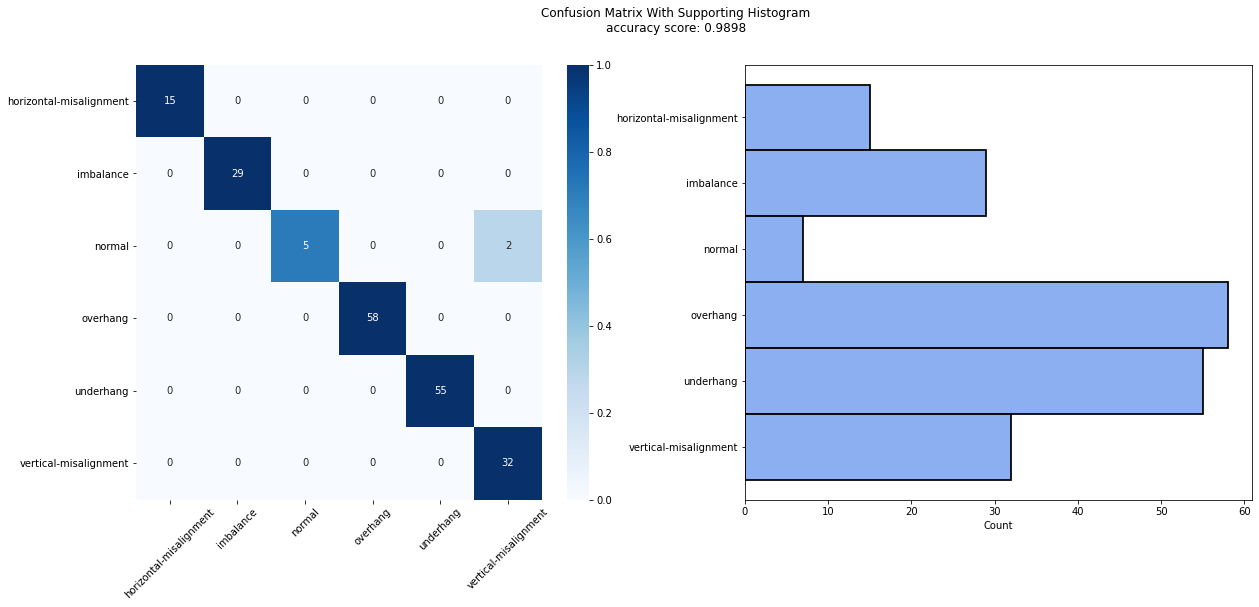

In [10]:
# used by the confusion_hist_plot function
target = 'class'

# define the model
model = RandomForestClassifier(bootstrap=True)
# fit the model with our training data
model.fit(X_train,y_train)
# try to predict the data points we set aside for testing
preds = model.predict(X_test)

#plot our results
confusion_hist_plot(df=df,y_test=y_test,preds=preds,codes=classDict)

#save our model
joblib.dump(model, "./models/rfc1.joblib")

In [11]:
# load the model
model = joblib.load('./models/rfc1.joblib')

In [13]:
val_files = df[['path','class','CLASS']].iloc[idxs]
val_files.head()
val_files.to_csv('./utils/test_files.csv')

In [14]:
S = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']

import itertools
Stats = ['-Entropy','-Kurtosis','-Mean','-F','-2F', '-3F'] # '-Std'
Signals = ['axialUnderhang', 'axialOverhang','radialUnderhang',
          'radialOverhang','tangentialUnderhang','tangentialOverhang',
           'microphone']
Others = ['tachometerSignal-Entropy','tachometerSignal-Kurtosis','tachometerSignal-Mean',
          #'tachometerSignal-Std','tachometerSignal-Min','tachometerSignal-Max',
          'fundamentalFrequency','class']
columns = [*itertools.product(Signals,Stats)]
for i,col in enumerate(columns):
    columns[i] = col[0]+col[1]
columns = columns + Others

In [15]:
utils = {}
utils['signals'] = S
utils['columns'] = columns
utils['classes'] = classDict
utils['idxs'] = idxs
print(utils)
with open('./utils/utils1.json', 'w') as file:
    file.write(json.dumps(utils))

{'signals': ['tachometerSignal', 'axialUnderhang', 'radialUnderhang', 'tangentialUnderhang', 'axialOverhang', 'radialOverhang', 'tangentialOverhang', 'microphone'], 'columns': ['axialUnderhang-Entropy', 'axialUnderhang-Kurtosis', 'axialUnderhang-Mean', 'axialUnderhang-F', 'axialUnderhang-2F', 'axialUnderhang-3F', 'axialOverhang-Entropy', 'axialOverhang-Kurtosis', 'axialOverhang-Mean', 'axialOverhang-F', 'axialOverhang-2F', 'axialOverhang-3F', 'radialUnderhang-Entropy', 'radialUnderhang-Kurtosis', 'radialUnderhang-Mean', 'radialUnderhang-F', 'radialUnderhang-2F', 'radialUnderhang-3F', 'radialOverhang-Entropy', 'radialOverhang-Kurtosis', 'radialOverhang-Mean', 'radialOverhang-F', 'radialOverhang-2F', 'radialOverhang-3F', 'tangentialUnderhang-Entropy', 'tangentialUnderhang-Kurtosis', 'tangentialUnderhang-Mean', 'tangentialUnderhang-F', 'tangentialUnderhang-2F', 'tangentialUnderhang-3F', 'tangentialOverhang-Entropy', 'tangentialOverhang-Kurtosis', 'tangentialOverhang-Mean', 'tangentialOver

In [ ]:
with open('./utils/utils.json', 'r') as file:
    

In [21]:
val_files[val_files['CLASS'] == 'vertical-misalignment'].index

Int64Index([194, 256,   7,  84,   9, 212, 134, 214,  60,  12,  10,   0, 285,
             30, 222, 228, 102, 249,  11, 145, 171, 209, 276,   6, 124,  34,
            104,  46, 260, 130, 300, 246],
           dtype='int64')

In [78]:
df = prepare_window_data(sensors=S, file_idxs=[1396,502,1944,1420])

In [90]:
df.iloc[500000]

tachometerSignal                                                -0.39615
axialUnderhang                                                   0.16088
radialUnderhang                                                  0.19383
tangentialUnderhang                                              0.28386
axialOverhang                                                    0.93314
radialOverhang                                                   0.07577
tangentialOverhang                                               0.33638
microphone                                                        0.2224
path                   ~/ML/MAFAULDA/data/full/overhang/cage_fault/20...
class                                                           overhang
Name: 0, dtype: object

In [94]:
[*df['path'].unique()]

['~/ML/MAFAULDA/data/full/normal/54.6816.csv',
 '~/ML/MAFAULDA/data/full/underhang/outer_race/6g/46.2848.csv',
 '~/ML/MAFAULDA/data/full/overhang/cage_fault/20g/19.456.csv',
 '~/ML/MAFAULDA/data/full/normal/29.4912.csv']

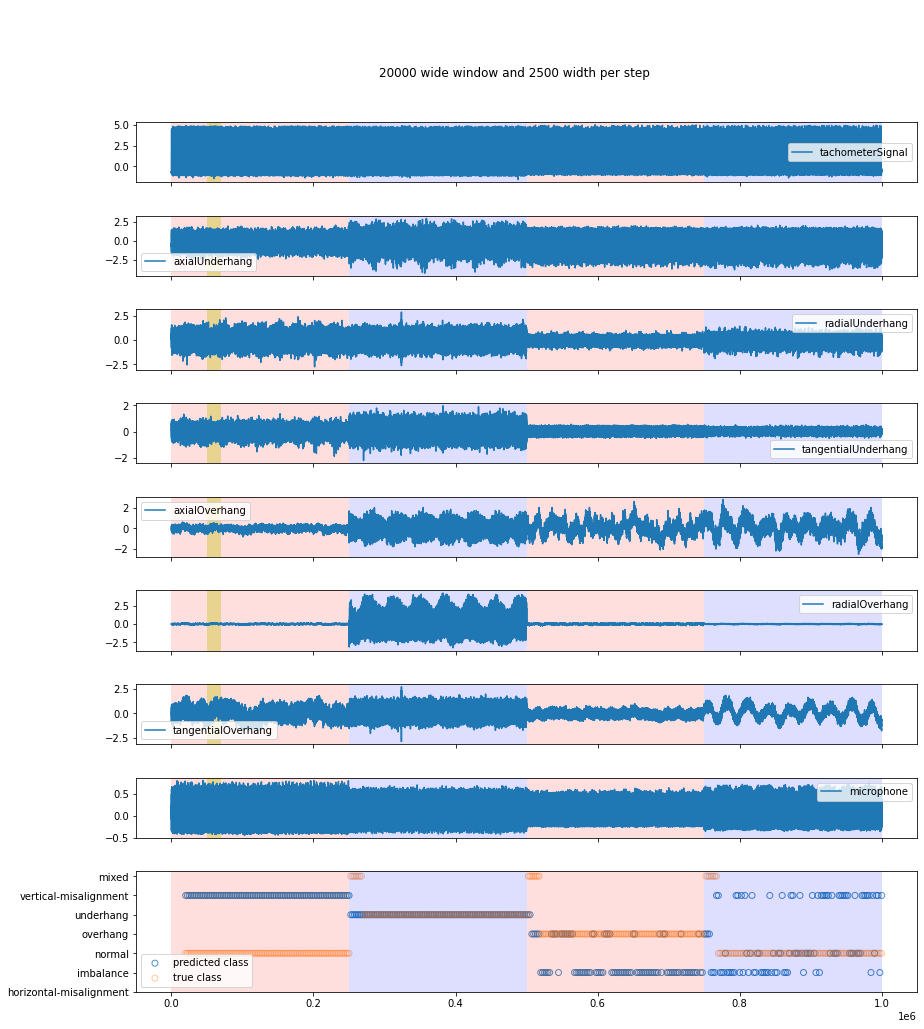

In [23]:
trues, preds = slide_window(window_model=model, df=df, columns=columns, num_files=4, width_per_step=2500, window_width= 20000)
plot_window(df,trues=trues,preds=preds,class_dict=classDict, n=4, width_per_step=2500, window_width=20000)

In [14]:
test_idxs = [1396,502,1418,990,1420,1823,1408,1296,1402,144]

In [4]:
val_files = pd.read_csv('./utils/val_files.csv').set_index('Unnamed: 0')

In [5]:
val_files

,path,class,CLASS
Unnamed: 0,,,
502,full/underhang/outer_race/6g/46.2848.csv,4,underhang
990,full/imbalance/6g/25.3952.csv,1,imbalance
1823,full/overhang/cage_fault/0g/50.5856.csv,3,overhang
1296,full/horizontal-misalignment/2.0mm/55.9104.csv,0,horizontal-misalignment
849,full/underhang/cage_fault/20g/22.3232.csv,4,underhang
...,...,...,...
144,full/vertical-misalignment/0.51mm/18.8416.csv,5,vertical-misalignment
69,full/vertical-misalignment/1.40mm/42.3936.csv,5,vertical-misalignment
731,full/underhang/cage_fault/0g/49.7664.csv,4,underhang


In [19]:
[*val_files[val_files['CLASS'] == 'horizontal-misalignment'].index]

[1296,
 1381,
 1226,
 1363,
 1255,
 1245,
 1247,
 1270,
 1373,
 1375,
 1241,
 1330,
 1331,
 1386,
 1224,
 1344,
 1257]

In [23]:
with open('./config/config.yaml','r') as stream:
    try:
        conf = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
conf

{'default': {'plot_path': '/Users/nrprzybyl/ML/MAFAULDA/window/plots/',
  'experiment_name': 'test1'},
 'sweep': {'random_pick': True,
  'n_files': 10,
  'file_idxs': [1396, 502, 1418, 990, 1420, 1823, 1408, 1296, 1402, 144],
  'width_per_step': {'lo': 2500, 'hi': 7500, 'step': 500},
  'window_width': {'lo': 10000, 'hi': 100000, 'step': 10000}}}

In [25]:
names = ['all_underhangs','all_overhangs','all_imbalance','all_vertical_misalignments','all_horizontal_misalignments','all_normals']
classes = ['underhang','overhang','imbalance','vertical-misalignment','horizontal-misalignment','vertical-misalignment','normal']
for i,n in enumerate(names):
    conf['default']['experiment_name'] = n
    conf['default']['plot_path'] = '/ac-project/nprzybylski/window/plots/'
    conf['sweep']['random_pick'] = False
    conf['sweep']['file_idxs'] = [*val_files[val_files['CLASS'] == classes[i]].index]
    conf['sweep']['width_per_step']['lo'] = 10000
    conf['sweep']['width_per_step']['hi'] = 10000
    conf['sweep']['window_width']['lo'] = 250000
    conf['sweep']['window_width']['hi'] = 250000
    conf['sweep']['window_width']['step'] = 500
    
    with open(f'./config', 'w') as file:
    documents = yaml.dump(dict_file, file)


{'default': {'plot_path': '/ac-project/nprzybylski/window/plots/',
  'experiment_name': 'all_normals'},
 'sweep': {'random_pick': False,
  'n_files': 10,
  'file_idxs': [194,
   256,
   7,
   84,
   9,
   212,
   134,
   214,
   60,
   12,
   10,
   0,
   285,
   30,
   222,
   228,
   102,
   249,
   11,
   145,
   171,
   209,
   276,
   6,
   124,
   34,
   104,
   46,
   260,
   130,
   300,
   246],
  'width_per_step': {'lo': 10000, 'hi': 10000, 'step': 500},
  'window_width': {'lo': 250000, 'hi': 250000, 'step': 500}}}

In [86]:
with open(f"./config/{conf['default']['experiment_name']}.yaml", 'w') as file:
    yaml.dump(conf,file)

In [134]:
# %matplotlib agg
n_iter = 1
n_files = 10
path = '/Users/nrprzybyl/ML/MAFAULDA/window/plots'


for n in range(n_iter):
    file_idxs = test_idxs #[*np.random.choice([*idxs],n_files,replace=False)]
    df = prepare_window_data(sensors=S, file_idxs=file_idxs)
    width_per_step = 2500
    window_width = 10000
    trues, preds = slide_window(window_model=model, df=df, columns=columns, num_files=n_files, width_per_step=width_per_step, window_width=window_width)
    
    fig = plot_window(df,trues=trues,preds=preds,class_dict=classDict, n=n_files, width_per_step=width_per_step, window_width=window_width)
    fig_name = ''
    for _ in file_idxs:
        fig_name+=f'{_}_'
    p = os.path.join(path,f'{window_width}_{width_per_step}')
    isDir = os.path.isdir(p)
    if not isDir:
        os.mkdir(p)
    fig_path = f'{path}/{window_width}_{width_per_step}/{fig_name[:-1]}'
    fig.savefig(fig_path)

In [4]:
def sweep_window(config='/Users/nrprzybyl/ML/MAFAULDA/window/config/config.yaml'):
    t = time.time()
    with open(config,'r') as stream:
        try:
            conf = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
            
    with open('/Users/nrprzybyl/ML/MAFAULDA/window/utils/utils.json', 'r') as file:
        utils = json.load(file)
        
    # load the model
    model = joblib.load('./models/rfc.joblib')
    
    idxs = utils['idxs']    
    S = utils['signals']
    columns = utils['columns']
    
    default = conf['default']
    plot_path = default['plot_path']
    experiment_name = default['experiment_name']
    path = os.path.join(plot_path,experiment_name)
    isDir = os.path.isdir(path)
    if not isDir:
        os.mkdir(path)
    
    sweep = conf['sweep']
    random_pick = sweep['random_pick']
    if not random_pick:
        file_idxs = sweep['file_idxs']
        n_files = len(file_idxs)
    else:
        n_files = sweep['n_files']
        file_idxs = [*np.random.choice([*idxs],n_files,replace=False)]
    width_per_step = sweep['width_per_step']
    window_width = sweep['window_width']
    wps = np.arange(width_per_step['lo'],width_per_step['hi']+width_per_step['step'],width_per_step['step'])
    ww = np.arange(window_width['lo'],window_width['hi']+window_width['step'],window_width['step'])
    params = [*itertools.product(wps,ww)]
    n_iters = len(params)
    
    meta = {}
    
    for i,p in enumerate(params):
        df = prepare_window_data(sensors=S, file_idxs=file_idxs)
        
        _width_per_step = p[0]
        _window_width = p[1]
        
        if i % 1 == 0:
            clear_output(wait=True)
            print(f'{i+1}/{n_iters} -- {round(100*((i+1)/(n_iters)),2)}%')
        
        _t = time.time()
        trues, preds = slide_window(window_model=model, df=df, columns=columns, num_files=n_files, width_per_step=_width_per_step, window_width=_window_width)
        _t = time.time() - _t
        
        overall_acc = accuracy_score(trues,preds)
        
        ######################################################
        
        t_zones = [ [] for _ in np.ones(n_files) ]
        p_zones = [ [] for _ in np.ones(n_files) ]
        
        zone_idxs = [ int((i*wps) // 250000) for i in range(len(trues)) ]
        
#         print(zone_idxs)
        for i,z in enumerate(zone_idxs):
#             print(z)
            p_zones[z].append(preds[i])
            t_zones[z].append(trues[i])
        
#         print(t_zones)
#         print(p_zones)
        
        ######################################################
        
        zones = []
        
        fig, acc = plot_window(df,trues=trues,preds=preds,class_dict=classDict, n=n_files, width_per_step=_width_per_step, window_width=_window_width)
        fig_name = ''
        for _ in file_idxs:
            fig_name+=f'{_}_'
        p = os.path.join(path,f'{_window_width}_{_width_per_step}')
        isDir = os.path.isdir(p)
        if not isDir:
            os.mkdir(p)
        run = f'{_window_width}_{_width_per_step}'
        fig_path = f'{path}/{run}/{fig_name[:-1]}'
        fig.savefig(fig_path)
        plt.close()
        
        fig1 = confusion_hist_plot(df=df,y_test=trues,preds=preds,codes=classDict)
        fig1.savefig(f'{fig_path} confusion.png')
        plt.close()
        
        meta[run] = {}
        meta[run]['overall_acc'] = overall_acc
        meta[run]['acc'] = acc
        
        meta[run]['time'] = _t
        
        ######################################################
        
        meta[run]['zones'] = {}
        meta[run]['zones'] = [ {} for _ in np.ones(n_files) ]
        for i in range(n_files):
            meta[run]['zones'][i]['acc'] = accuracy_score(t_zones[i],p_zones[i])
            
    file_paths = [*df['path'].unique()]
    meta[run]['file_paths'] = file_paths
        
        ######################################################
    
    t = time.time() - t
    meta[run]['time'] = t
    with open(f'{path}/out', 'w') as file:
        file.write(json.dumps(meta))
        
    

In [ ]:
t = {}
t['zones'] = [ {} for _ in np.ones(4) ]
for i in range(4):
    
    t['zones'][i]['acc'] = 1
t

In [5]:
sweep_window(config='config/with_times_random.yaml')

1/11 -- 9.09%


NameError: name 'classDict' is not defined

In [87]:
with open('plots/all_normals/out','r') as file:
    t = json.load(file)
t

{'1000_10000': {'overall_acc': 0.03428571428571429,
  'acc': 0.03428571428571429,
  'time': 5.770684003829956,
  'zones': [{'acc': 0.0},
   {'acc': 0.08},
   {'acc': 0.16},
   {'acc': 0.0},
   {'acc': 0.0},
   {'acc': 0.0},
   {'acc': 0.0}]},
 '6000_10000': {'overall_acc': 0.17714285714285713,
  'acc': 0.17714285714285713,
  'time': 7.27384090423584,
  'zones': [{'acc': 0.0},
   {'acc': 0.28},
   {'acc': 0.2},
   {'acc': 0.64},
   {'acc': 0.12},
   {'acc': 0.0},
   {'acc': 0.0}]},
 '11000_10000': {'overall_acc': 0.25862068965517243,
  'acc': 0.25862068965517243,
  'time': 8.40053415298462,
  'zones': [{'acc': 0.0},
   {'acc': 0.48},
   {'acc': 0.24},
   {'acc': 0.36},
   {'acc': 0.56},
   {'acc': 0.16},
   {'acc': 0.0}]},
 '16000_10000': {'overall_acc': 0.27586206896551724,
  'acc': 0.27586206896551724,
  'time': 9.573869943618774,
  'zones': [{'acc': 0.04},
   {'acc': 0.8},
   {'acc': 0.52},
   {'acc': 0.48},
   {'acc': 0.08},
   {'acc': 0.0},
   {'acc': 0.0}]},
 '21000_10000': {'over

In [2]:
dirs = ['all_normals','all_overhangs','all_vertical_misalignments','all_horizontal_misalignments','all_imbalance','all_underhangs']
labels = ['normal','overhang','vertical-misalignment','horizontal-misalignment','imbalance','underhang']
accs = []
for d in dirs:
    with open(f'plots/{d}/out','r') as file:
        t = json.load(file)
        accs.append([t[_]['acc'] for _ in t])

In [38]:
accs1 = []
for d in dirs:
    with open(f'plots/test/plots/{d}/out','r') as file:
        t = json.load(file)
        accs1.append([t[_]['acc'] for _ in t])
accs1 = np.array(accs1)[:,:-1]

In [44]:
[*accs1[0]]

[0.03428571428571429,
 0.17714285714285713,
 0.25862068965517243,
 0.27586206896551724,
 0.36416184971098264,
 0.34104046242774566,
 0.36627906976744184,
 0.36046511627906974,
 0.4502923976608187,
 0.4269005847953216]

In [45]:
all_accs = []
for i,_ in enumerate(accs):
    all_accs.append([*accs1[i]]+_)

In [49]:
len(accs1[0])

10

In [108]:
np.arange(1000,55000,5000)

array([ 1000,  6000, 11000, 16000, 21000, 26000, 31000, 36000, 41000,
       46000, 51000])

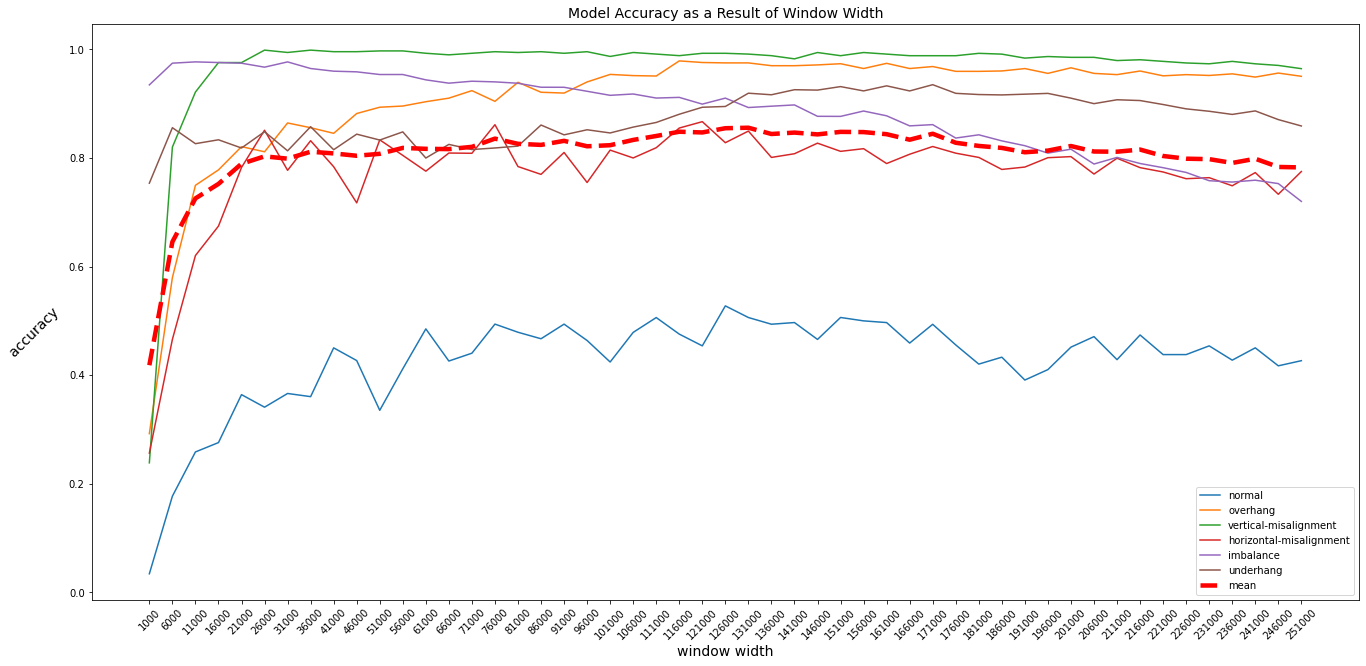

In [78]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
for i,a in enumerate(all_accs):
    ax.plot(a,label=labels[i])
plt.plot(means,label='mean',linewidth=4.5,linestyle='dashed',color='r')
plt.legend()
l=np.arange(1000,256000,5000)
ax.set_xticks(np.arange(len(l)))
ax.set_xticklabels(l,rotation=45)
plt.xlabel('window width',fontdict={'size':14})
plt.ylabel('accuracy                ',rotation=45,fontdict={'size':14})
plt.title('Model Accuracy as a Result of Window Width',fontdict={'size':14});

In [60]:
n = np.array(all_accs)

In [68]:
means = []
for i in range(len(n[0])):
    means.append(np.mean(n[:,i]))

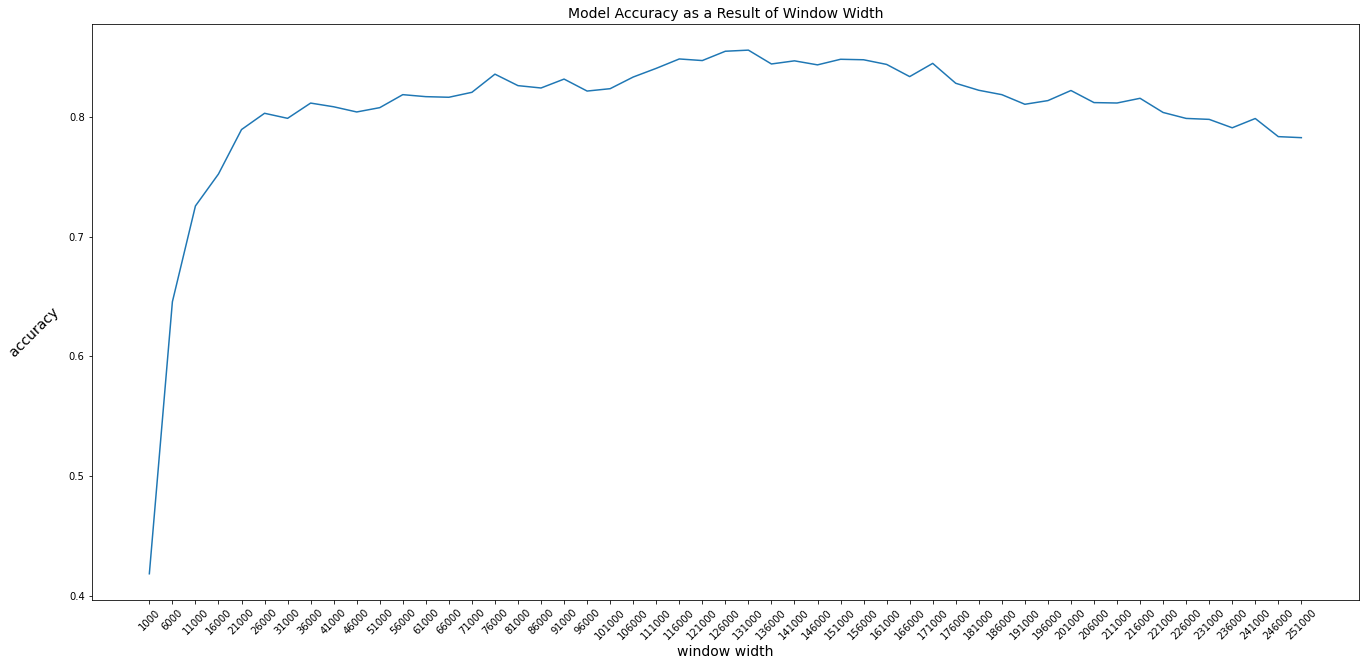

In [69]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.plot(means)
ax.set_xticks(np.arange(len(l)))
ax.set_xticklabels(l,rotation=45)
plt.xlabel('window width',fontdict={'size':14})
plt.ylabel('accuracy                ',rotation=45,fontdict={'size':14})
plt.title('Model Accuracy as a Result of Window Width',fontdict={'size':14});

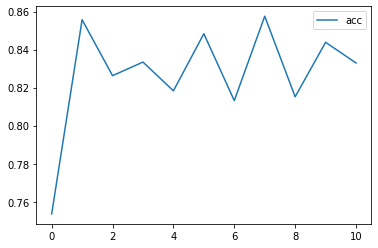

In [103]:
plt.plot([t[_]['acc'] for _ in t],label='acc')
# plt.plot([t[_]['overall_acc'] for _ in t],label='overall_acc')
plt.legend()

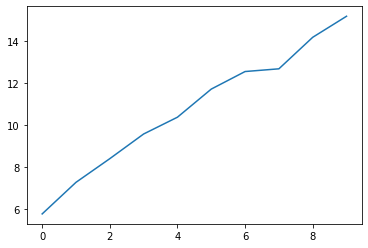

In [90]:
plt.plot([t[_]['time'] for _ in t][:-1])

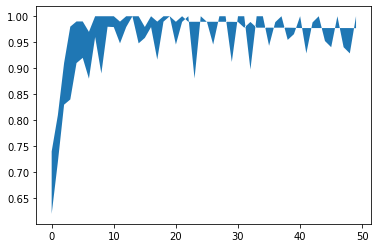

In [7]:
y = []
for i in range(1,5):
    with open(f'plots/test{i}_random/out','r') as file:
        j = json.load(file)
    y.append([j[_]['acc'] for _ in j])
plt.fill_between(np.arange(len(y[0])),*y)

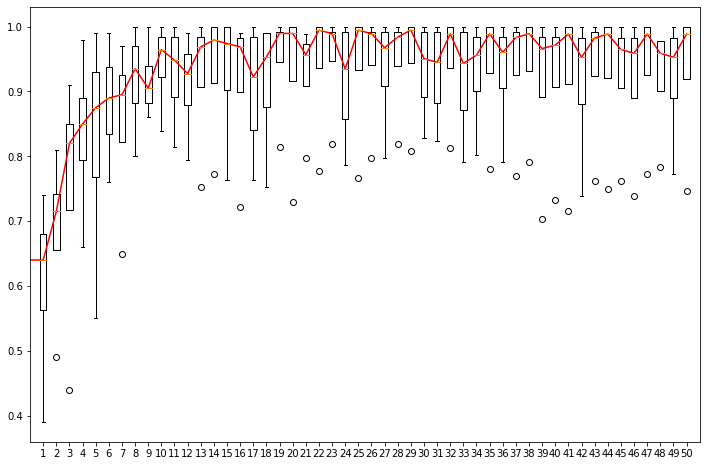

In [55]:
plt.figure(figsize=(12,8))
plt.boxplot(np.array(y));
plt.xlim(0,51)
plt.plot([np.median(np.array(y).T[0])]+[np.median(_) for _ in np.array(y).T],color='r');

In [412]:
file_idxs = conf['sweep']['file_idxs'][:5]
n_files = len(file_idxs)
_window_width = 10000
_width_per_step = 10000
print(f'file indices: {file_idxs}')
print(f'# files: {n_files}')
print(f'window width: {_window_width}')
print(f'width per step: {_width_per_step}')

file indices: [1396, 502, 1418, 990, 1420]
# files: 5
window width: 10000
width per step: 10000


In [413]:
%%time
df = prepare_window_data(sensors=S, file_idxs=file_idxs)

CPU times: user 1.01 s, sys: 209 ms, total: 1.22 s
Wall time: 1.22 s


In [414]:
%%time
trues, preds = slide_window(window_model=model, df=df, columns=columns, num_files=n_files, width_per_step=_width_per_step, window_width=_window_width)

CPU times: user 5.82 s, sys: 126 ms, total: 5.95 s
Wall time: 5.95 s


CPU times: user 1.68 s, sys: 335 ms, total: 2.01 s
Wall time: 820 ms


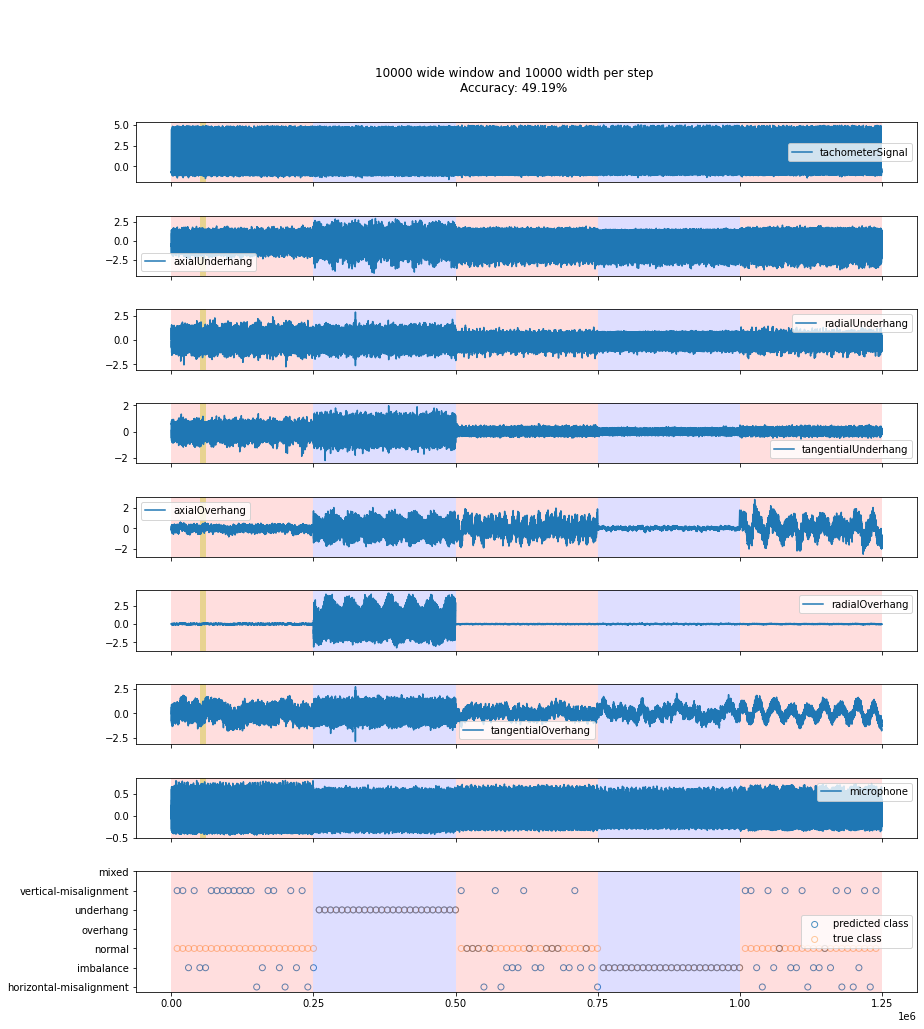

In [415]:
%%time
fig = plot_window(df,trues=trues,preds=preds,class_dict=classDict, n=n_files, width_per_step=_width_per_step, window_width=_window_width)

In [416]:
print(f'trues: {len(trues)}')
print(f'preds: {len(preds)}')

trues: 124
preds: 124


In [296]:
file_idxs = conf['sweep']['file_idxs'][:5]
n_files = len(file_idxs)
_window_width = 5000
_width_per_step = 40000
print(f'file indices: {file_idxs}')
print(f'# files: {n_files}')
print(f'window width: {_window_width}')
print(f'width per step: {_width_per_step}')
print(f'max idx: {n_files*250000}')

file indices: [1396, 502, 1418, 990, 1420]
# files: 5
window width: 5000
width per step: 40000
max idx: 1250000


0:5000
FROM EFF -- len: 2500
FROM EFF -- maxIdx: 5
FROM EFF -- maxIdx: 11
FROM EFF -- maxIdx: 16
FROM EFF -- maxIdx: 21
40000:45000
FROM EFF -- len: 2500
FROM EFF -- maxIdx: 11
FROM EFF -- maxIdx: 5
FROM EFF -- maxIdx: 16
FROM EFF -- maxIdx: 27
80000:85000
FROM EFF -- len: 2500
FROM EFF -- maxIdx: 5
FROM EFF -- maxIdx: 11
FROM EFF -- maxIdx: 16
FROM EFF -- maxIdx: 21
120000:125000
FROM EFF -- len: 2500
FROM EFF -- maxIdx: 5
FROM EFF -- maxIdx: 11
FROM EFF -- maxIdx: 16
FROM EFF -- maxIdx: 21
160000:165000
FROM EFF -- len: 2500
FROM EFF -- maxIdx: 5
FROM EFF -- maxIdx: 11
FROM EFF -- maxIdx: 16
FROM EFF -- maxIdx: 21
200000:205000
FROM EFF -- len: 2500
FROM EFF -- maxIdx: 5
FROM EFF -- maxIdx: 16
FROM EFF -- maxIdx: 11
FROM EFF -- maxIdx: 21
240000:245000
FROM EFF -- len: 2500
FROM EFF -- maxIdx: 5
FROM EFF -- maxIdx: 11
FROM EFF -- maxIdx: 16
FROM EFF -- maxIdx: 21
280000:285000
FROM EFF -- len: 2500
FROM EFF -- maxIdx: 9
FROM EFF -- maxIdx: 5
FROM EFF -- maxIdx: 18
FROM EFF -- maxIdx:

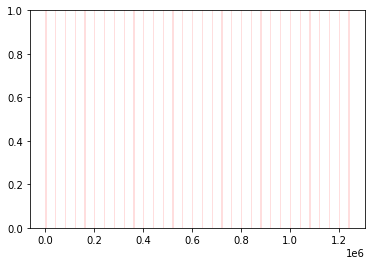

In [342]:
for i in range(0,(250000*n_files)-_window_width,_width_per_step):
    print(f'{i}:{i+_window_width}')
    plt.axvspan(i, i+_window_width, facecolor='red', alpha=0.13)
    estimate_fundamental_frequency([*df.iloc[i:i+_window_width]['tachometerSignal']],1/50000)
#     data = df.iloc[i:i+window_width]
#     summarized = summarize(df=data,columns=columns)
#     X = summarized.drop(columns=['class'])
#     y = summarized['class'].map(classDict).values[0]
#     pred = window_model.predict(X)[0]
#     preds.append(pred)
#     trues.append(y)



In [350]:
summarize(df=df.iloc[0:2446],columns=columns)

FROM EFF -- len: 1223
FROM EFF -- maxIdx: 5
FROM EFF -- maxIdx: 13
FROM EFF -- maxIdx: 26
FROM EFF -- maxIdx: 9


,class,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F,axialUnderhang-3F,axialOverhang-Entropy,axialOverhang-Kurtosis,axialOverhang-Mean,...,microphone-Entropy,microphone-Kurtosis,microphone-Mean,microphone-F,microphone-2F,microphone-3F,tachometerSignal-Entropy,tachometerSignal-Kurtosis,tachometerSignal-Mean,fundamentalFrequency
0,normal,7.795408,-0.462314,-0.021002,0.092601,0.027358,0.164565,7.778758,-0.803412,-0.056877,...,7.743758,-0.597102,0.012423,0.006426,0.006087,0.007612,7.639691,1.505863,0.108049,102.207686


In [307]:
xf, yf = do_fft([*df.iloc[760000:765000]['tachometerSignal']],1/50000)
print(len(xf))
print(len(yf))

2500
2500


In [383]:
t=estimate_fundamental_frequency([*df.iloc[760000:760101]['tachometerSignal']],1/50000)

In [306]:
df.iloc[760000:765000]['tachometerSignal']

10000   -0.78505
10001   -0.74410
10002   -0.66629
10003   -0.65415
10004   -0.75565
          ...   
14995    4.42540
14996    4.46030
14997    4.42130
14998    4.45740
14999    4.42750
Name: tachometerSignal, Length: 5000, dtype: float64

In [321]:
yf[]

0.003536483770043188

In [323]:
1 - 3

-2

In [330]:
k=1

In [332]:
k=1
k-=4
if k < 0:
    k-=k
k

0

0

In [339]:
t = np.arange(0,20)

In [340]:
t[4:11]

array([ 4,  5,  6,  7,  8,  9, 10])

In [386]:
len(t[2])

50

In [419]:
np.arange(5000,5000,10)

ZeroDivisionError: division by zero

In [470]:
np.arange(1000,55000,5000)

array([ 1000,  6000, 11000, 16000, 21000, 26000, 31000, 36000, 41000,
       46000, 51000])

## Data to save after each run

        - accuracy
            - overall (maybe)
            - minus "mixed" areas (current)
            - per zone
            - per class (maybe save confusion matrix for this part)
            
        - metadata (by zone)
            - source file path
                - class
                - weight/misalignment/rpm/type of fault(ball, outer race, cage)

## Example output

In [464]:
from pprint import pprint
test1 = {   
    '1000_10000': {
        'overall_acc': 30,
        'acc': 35,
        'zones': {
            '1': { 'acc': 40, 'path': 'full/overhang/ball_fault/6g/12.6976.csv' },
            '2': { 'acc': 30, 'path': 'full/normal/12.288.csv' }
        }
    },
    '2000_10000': {
        'overall_acc': 40,
        'acc': 45,
        'zones': {
            '1': { 'acc': 50, 'path': 'full/overhang/ball_fault/6g/12.6976.csv' },
            '2': { 'acc': 40, 'path': 'full/normal/12.288.csv' }
        }
    }
}
pprint(test1)

{'1000_10000': {'acc': 35,
                'overall_acc': 30,
                'zones': {'1': {'acc': 40,
                                'path': 'full/overhang/ball_fault/6g/12.6976.csv'},
                          '2': {'acc': 30, 'path': 'full/normal/12.288.csv'}}},
 '2000_10000': {'acc': 45,
                'overall_acc': 40,
                'zones': {'1': {'acc': 50,
                                'path': 'full/overhang/ball_fault/6g/12.6976.csv'},
                          '2': {'acc': 40, 'path': 'full/normal/12.288.csv'}}}}


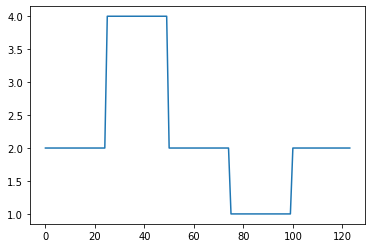

In [450]:
plt.plot(trues)

In [452]:
len(trues)//5

24

In [453]:
24*4

96

In [458]:
trues[100]

2

In [65]:
columns

['axialUnderhang-Entropy',
 'axialUnderhang-Kurtosis',
 'axialUnderhang-Mean',
 'axialUnderhang-F',
 'axialUnderhang-2F',
 'axialUnderhang-3F',
 'axialOverhang-Entropy',
 'axialOverhang-Kurtosis',
 'axialOverhang-Mean',
 'axialOverhang-F',
 'axialOverhang-2F',
 'axialOverhang-3F',
 'radialUnderhang-Entropy',
 'radialUnderhang-Kurtosis',
 'radialUnderhang-Mean',
 'radialUnderhang-F',
 'radialUnderhang-2F',
 'radialUnderhang-3F',
 'radialOverhang-Entropy',
 'radialOverhang-Kurtosis',
 'radialOverhang-Mean',
 'radialOverhang-F',
 'radialOverhang-2F',
 'radialOverhang-3F',
 'tangentialUnderhang-Entropy',
 'tangentialUnderhang-Kurtosis',
 'tangentialUnderhang-Mean',
 'tangentialUnderhang-F',
 'tangentialUnderhang-2F',
 'tangentialUnderhang-3F',
 'tangentialOverhang-Entropy',
 'tangentialOverhang-Kurtosis',
 'tangentialOverhang-Mean',
 'tangentialOverhang-F',
 'tangentialOverhang-2F',
 'tangentialOverhang-3F',
 'microphone-Entropy',
 'microphone-Kurtosis',
 'microphone-Mean',
 'microphone-F'

In [70]:
[*itertools.combinations(columns, 5)]

[('axialUnderhang-Entropy',
  'axialUnderhang-Kurtosis',
  'axialUnderhang-Mean',
  'axialUnderhang-F',
  'axialUnderhang-2F'),
 ('axialUnderhang-Entropy',
  'axialUnderhang-Kurtosis',
  'axialUnderhang-Mean',
  'axialUnderhang-F',
  'axialUnderhang-3F'),
 ('axialUnderhang-Entropy',
  'axialUnderhang-Kurtosis',
  'axialUnderhang-Mean',
  'axialUnderhang-F',
  'axialOverhang-Entropy'),
 ('axialUnderhang-Entropy',
  'axialUnderhang-Kurtosis',
  'axialUnderhang-Mean',
  'axialUnderhang-F',
  'axialOverhang-Kurtosis'),
 ('axialUnderhang-Entropy',
  'axialUnderhang-Kurtosis',
  'axialUnderhang-Mean',
  'axialUnderhang-F',
  'axialOverhang-Mean'),
 ('axialUnderhang-Entropy',
  'axialUnderhang-Kurtosis',
  'axialUnderhang-Mean',
  'axialUnderhang-F',
  'axialOverhang-F'),
 ('axialUnderhang-Entropy',
  'axialUnderhang-Kurtosis',
  'axialUnderhang-Mean',
  'axialUnderhang-F',
  'axialOverhang-2F'),
 ('axialUnderhang-Entropy',
  'axialUnderhang-Kurtosis',
  'axialUnderhang-Mean',
  'axialUnderha

In [16]:
l = [*itertools.combinations(columns, 5)]

In [18]:
l[0]

('axialUnderhang-Entropy',
 'axialUnderhang-Kurtosis',
 'axialUnderhang-Mean',
 'axialUnderhang-F',
 'axialUnderhang-2F')

In [37]:
X_train[ [ *l[0] ] ]

,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F
118,11.710706,-0.005690,0.013995,0.093056,0.051129
1057,11.706825,-0.066016,-0.001894,0.279068,0.089440
1797,11.518458,-0.564332,0.022273,0.220204,0.008050
1272,11.621502,-0.344782,0.009457,0.182446,0.017823
1707,11.428100,-0.687758,0.011348,0.176764,0.032799
...,...,...,...,...,...
1568,11.560696,0.228981,0.033435,0.162871,0.035984
1916,11.655207,1.165479,0.013687,0.421072,0.015660
1667,11.371367,-0.738509,0.018703,0.169184,0.012351
414,11.639604,1.292972,0.005518,1.052607,0.046008


In [64]:
# used by the confusion_hist_plot function
target = 'class'
for i in range(10):
    t = time.time()
    # define the model
    model = RandomForestClassifier(bootstrap=True)
    # fit the model with our training data
    model.fit(X_train[[*l[0]]],y_train)
    # try to predict the data points we set aside for testing
    preds = model.predict(X_test[[*l[0]]])
    print(((time.time() - t) * len(l))/60/60)
#plot our results
# confusion_hist_plot(df=df,y_test=y_test,preds=preds,codes=classDict)

133.45777113795282
122.2374951350689
131.3436073333025
127.68468475619952
125.97128863255183
121.88802978078525
121.19001337110996
121.5083925630649
163.742702870965
135.22399341980616


In [68]:
len(l)

1533939

In [61]:
f = [*np.arange(50)]
#f'{[t+=f'{_}_' for _ in f[:5]]}\...{f[-5:]}'

In [80]:
t1 = ''
t2 = ''
for i in range(5):
    t1+=f'{f[i]}_'
    t2 = f'{f[-i-1]}_'+t2
t = f'{t1[:-1]}...{t2[:-1]}.png'
t

'0_1_2_3_4...45_46_47_48_49.png'

In [73]:
f[-1]

49

In [74]:
f

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [82]:
s1,s2 = '',''